In [ ]:
# This program uses an RNN called Long Short Term Memory to predict stock prices of a well known company
#Estimation based on 60 days of history. 

In [9]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from pandas_datareader import data as pdr
from datetime import datetime,date

import yfinance as yf


In [13]:
# Get the stock quote
yf.pdr_override()
from datetime import datetime
startdate = datetime(1990,1,1)
today = date.today()
enddate = today

data = pdr.get_data_yahoo('GOOG', start=startdate, end=enddate)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2023-05-15,116.489998,118.794998,116.480003,116.959999,116.959999,22107900
2023-05-16,116.830002,121.199997,116.830002,120.089996,120.089996,32370100
2023-05-17,120.180000,122.279999,119.459999,121.480003,121.480003,26659600


In [15]:
data.shape

(4721, 6)

Text(0, 0.5, 'Close $')

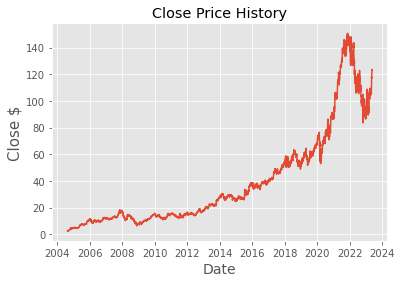

In [17]:
# Closing prices visual
plt.figure()
plt.title("Close Price History")
plt.plot(data["Close"])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Close $', fontsize=15)


In [19]:
datacl= data.filter(['Close'])
dataclose= datacl.values
training_data_length= math.ceil(len(dataclose) * 0.8)

training_data_length


3777

In [20]:
# Scaling data
scaler= MinMaxScaler(feature_range=(0,1))
scaleddata= scaler.fit_transform(dataclose)

In [27]:
# Training set
train_data= scaleddata[0:training_data_length,:]

In [28]:
x_train=[] #train features
y_train=[] #targets

for i in range(60,len(train_data)): #pass last 60 day data as training data and predict 61st day data
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])


In [30]:
x_train= np.array(x_train)
y_train= np.array(y_train)

(3717, 60)

In [32]:
# LSTM expects an input of 3 dimensions: samples, steps, features
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(3717, 60, 1)

In [33]:
# Building the LSTM model (sequential)

model= Sequential()
model.add(LSTM(60,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [34]:
model.compile(optimizer='Adam',loss='mean_squared_error')

In [37]:
#Training
model.fit(x_train,y_train,batch_size=32,epochs=1)

117/117 [==============================] - 2s 21ms/step - loss: 4.9878e-05


In [51]:
#Test set
test_data= scaleddata[training_data_length-60:,:]

x_test=[]
y_test=dataclose[training_data_length:,:]

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,:]) # still scaled

x_test=np.array(x_test)

In [54]:
#x_test= np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


0.36578928215479334

In [55]:
# Predictions
preds= model.predict(x_test)

30/30 [==============================] - 1s 8ms/step


In [57]:
preds=scaler.inverse_transform(preds)

In [60]:
rmse=np.sqrt(np.mean(((preds- y_test)**2)))


4.061479917674694

C:\Users\ulas0\AppData\Local\Temp\ipykernel_5164\963260394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


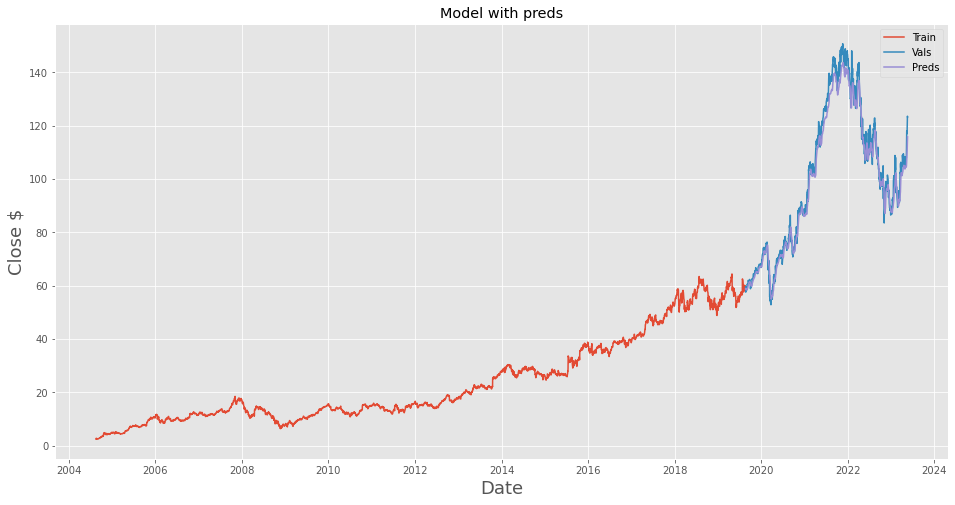

In [69]:
train= datacl[:training_data_length]
valid= datacl[training_data_length:]
valid['Predictions'] = preds

plt.figure(figsize=(16,8))
plt.title("Model with preds")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close $",fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Vals', 'Preds'])
plt.show()


In [71]:
valid

,Close,Predictions
Date,,
2019-08-21,59.562500,58.777985
2019-08-22,59.476501,58.873142
2019-08-23,57.564499,58.961933
2019-08-26,58.444500,58.791325
2019-08-27,58.391998,58.640598
...,...,...
2023-05-15,116.959999,109.251488
2023-05-16,120.089996,110.814209
2023-05-17,121.480003,112.485832


In [85]:
#Predict the price for tomorrow (or Monday, since market is closed on weekends)
goog_quote= data
new_df= goog_quote.filter(['Close'])
lastsd= new_df[-60:].values
lastsd_scaled= scaler.transform(lastsd)
X_test=[]
X_test.append(lastsd_scaled)
X_test=np.array(X_test)
X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))




In [86]:
pred_nprice= model.predict(X_test)
pred_nprice= scaler.inverse_transform(pred_nprice)
print(pred_nprice)

1/1 [==============================] - 0s 19ms/step
[[117.172905]]
